# Image Classification

This notebook uses transfer learning to perform an image classification. The program classifies images of cats and dogs [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip) using the pretrained network [Densenet121](https://pytorch.org/docs/0.3.0/torchvision/models.html#id5).

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Load / Preprocessing input data (images)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/Colab Notebooks/Image Classification/Cat_Dog_data/'

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),                                     
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

train_dataset = datasets.ImageFolder(file_path + 'train', transform=train_transform)
test_dataset = datasets.ImageFolder(file_path + 'test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

classes = ['cat', 'dog']

In [3]:
print(len(train_dataset))

22500


## Data visualization

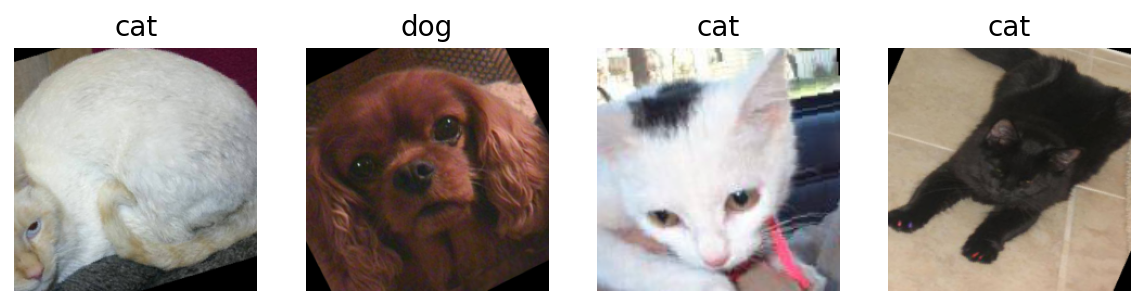

In [4]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

images, labels = next(iter(train_loader))

fig, axis = plt.subplots(ncols=4, figsize=(10,4))
for ii in range(4):
    ax = axis[ii]
    imshow(images[ii], ax=ax)
    ax.set_title(classes[labels[ii]], fontsize=14)

## Load pretrained model

In [5]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Setup pretrained model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('device:', device)

for para in model.parameters():
    para.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 256)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2', nn.Linear(256, 2)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

model.classifier = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model = model.to(device)

device: cuda


## Train and Test the Model

In [7]:
epochs = 1
step = 0
print_every = 10

for epoch in range(1, epochs+1):
        
    for inputs, labels in train_loader:
        
        step += 1
        train_loss = 0
        
        model.train()
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if step % print_every == 0:
            
            with torch.no_grad():

                model.eval()

                test_loss = 0
                accuracy = 0

                for inputs, labels in test_loader:

                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model.forward(inputs)
                    loss = criterion(outputs, labels)

                    test_loss += loss.item()

                    out_probs = torch.exp(outputs)
                    top_prob, top_class = out_probs.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            print('Step: {:3d} -- Train Loss: {:.4f} -- Test Loss: {:.4f} -- Accuracy: {:.2f}'.format(
                step, train_loss/print_every, test_loss/len(test_loader), accuracy/len(test_loader)))

Step:  10 -- Train Loss: 0.0287 -- Test Loss: 0.1914 -- Accuracy: 0.94
Step:  20 -- Train Loss: 0.0173 -- Test Loss: 0.1283 -- Accuracy: 0.95
Step:  30 -- Train Loss: 0.0201 -- Test Loss: 0.0623 -- Accuracy: 0.98
Step:  40 -- Train Loss: 0.0273 -- Test Loss: 0.0657 -- Accuracy: 0.98
Step:  50 -- Train Loss: 0.0261 -- Test Loss: 0.0603 -- Accuracy: 0.98
Step:  60 -- Train Loss: 0.0232 -- Test Loss: 0.0537 -- Accuracy: 0.98
Step:  70 -- Train Loss: 0.0171 -- Test Loss: 0.0580 -- Accuracy: 0.98
Step:  80 -- Train Loss: 0.0122 -- Test Loss: 0.0500 -- Accuracy: 0.98
Step:  90 -- Train Loss: 0.0203 -- Test Loss: 0.0575 -- Accuracy: 0.98
Step: 100 -- Train Loss: 0.0195 -- Test Loss: 0.0735 -- Accuracy: 0.98
Step: 110 -- Train Loss: 0.0179 -- Test Loss: 0.0796 -- Accuracy: 0.97
Step: 120 -- Train Loss: 0.0358 -- Test Loss: 0.1003 -- Accuracy: 0.96
Step: 130 -- Train Loss: 0.0123 -- Test Loss: 0.0552 -- Accuracy: 0.98
Step: 140 -- Train Loss: 0.0263 -- Test Loss: 0.0560 -- Accuracy: 0.98
Step: 

## Save the Model

In [8]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Load the trained Model for Inference

In [9]:
state_dict = torch.load('checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

## Inference

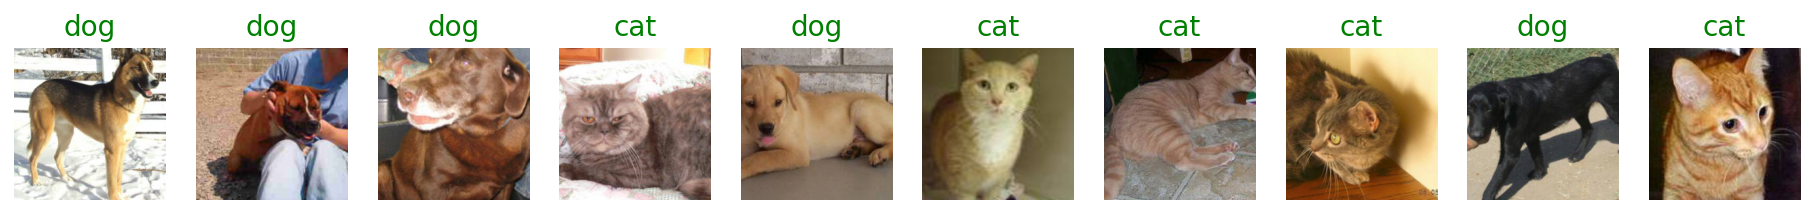

In [18]:
model.eval()

iterator = iter(test_loader)
images, labels = iterator.next()
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model.forward(images)

out_probs = torch.exp(outputs)
_, predict_class = torch.max(out_probs, dim=1)

#idx = np.random.randint(len(test_loader))

ncols = 10

fig, axis = plt.subplots(ncols=ncols, figsize=(16, 4))

for ii, idx in enumerate(range(ncols)):
    image = images[idx]
    label = labels[idx]
    prdct = predict_class[idx]

    ax = axis[ii]

    imshow(image.cpu(), ax=ax)

    if label.item() == prdct.item():
        ax.set_title(classes[prdct.item()], fontsize=14, color='green')
    else:
        ax.set_title(classes[prdct.item()], fontsize=14, color='red')
